In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses

from lob.lob_gan import *

%load_ext autoreload
%autoreload 2

imported at 2025-04-09 02:56:34.931555


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
RAW_DATA = pd.read_parquet('lob/BTCUSDT-lob.parq', engine='pyarrow')
assert RAW_DATA.notna().all(axis=None)
RAW_DATA

,E,T,U,u,pu,b0p,b1p,b2p,b3p,b4p,...,a0q,a1q,a2q,a3q,a4q,a5q,a6q,a7q,a8q,a9q
0,1739868923498,1739868923498,6783640382776,6783640393900,6783640382281,95179.9,95179.5,95179.0,95178.7,95178.0,...,8.937,0.190,0.036,0.002,0.095,0.002,0.002,0.002,0.158,0.002
1,1739868923614,1739868923610,6783640396586,6783640404328,6783640393900,95179.9,95179.5,95179.0,95178.7,95178.0,...,8.953,0.154,0.002,0.095,0.002,0.002,0.002,0.158,0.002,0.002
2,1739868923724,1739868923721,6783640405138,6783640420666,6783640404328,95179.9,95179.5,95179.0,95178.7,95178.0,...,8.953,0.154,0.042,0.002,0.095,0.002,0.002,0.002,0.158,0.004
3,1739868923827,1739868923821,6783640421340,6783640434389,6783640420666,95179.9,95179.5,95179.0,95178.7,95178.0,...,8.953,0.154,0.042,0.002,0.095,0.002,0.002,0.002,0.158,0.004
4,1739868923948,1739868923946,6783640436896,6783640445572,6783640434389,95179.9,95179.5,95179.0,95178.7,95178.0,...,8.957,0.154,0.042,0.002,0.095,0.002,0.002,0.002,0.158,0.004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189755,1739937377488,1739937377486,6791359179849,6791359186272,6791359179542,95733.3,95733.2,95733.1,95733.0,95732.9,...,0.884,0.007,0.002,0.014,0.050,0.002,0.002,0.002,0.002,0.010
189756,1739937377596,1739937377595,6791359186752,6791359194092,6791359186272,95733.3,95733.2,95733.1,95733.0,95732.9,...,1.438,0.007,0.002,0.014,0.050,0.002,0.002,0.002,0.002,0.010
189757,1739937377698,1739937377697,6791359194379,6791359202977,6791359194092,95733.3,95733.2,95733.1,95733.0,95732.9,...,5.604,0.007,0.002,0.014,0.002,0.050,0.002,0.002,0.002,0.002
189758,1739937377806,1739937377806,6791359203537,6791359209077,6791359202977,95733.3,95733.2,95733.1,95733.0,95732.9,...,5.453,0.007,0.002,0.014,0.002,0.050,0.002,0.002,0.002,0.002


In [4]:
SEED = 0
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [5]:
%%time

SAMPLE_SIZE = min(len(RAW_DATA), Configs().sample_size)
BATCH_SIZE = SAMPLE_SIZE // Configs().n_batches

LOB_DATASET = create_dataset(RAW_DATA, sample_size=SAMPLE_SIZE, batch_size=BATCH_SIZE)

CPU times: user 21.1 ms, sys: 9.18 ms, total: 30.3 ms
Wall time: 29.3 ms


{'neg_qty_sum': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 'neg_qty_count': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 'neg_diff_sum': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 'neg_diff_count': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>}

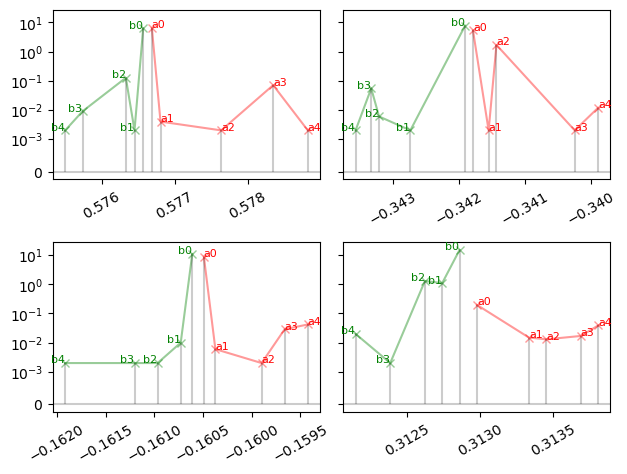

CPU times: user 1.04 s, sys: 80.1 ms, total: 1.12 s
Wall time: 509 ms


In [6]:
%%time

for i, batch in enumerate(LOB_DATASET):
    ss = calculate_sample_stats(batch)
    display(ss)
    f, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, sharey=True)
    plot_lob_snapshot(batch[0], ax0)
    plot_lob_snapshot(batch[1], ax1)
    plot_lob_snapshot(batch[2], ax2)
    plot_lob_snapshot(batch[3], ax3)
    plt.tight_layout()
    plt.show()
    break

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [01:05<00:00,  1.03s/it]

Training completed in 1.10 minutes
plot_training_history


,disc_loss,gen_loss,adv_loss,fm_loss,real_prob,fake_prob,neg_qty_sum,neg_qty_count,neg_diff_sum,neg_diff_count
0,2.169994,2.630141,2.630141,0.0,0.556099,0.402829,15.347047,3.73265,59.267348,16.365000
1,2.298718,5.989669,5.989669,0.0,0.448741,0.153266,71.380920,4.31715,281.405411,23.759849
2,0.165302,10.747576,10.747576,0.0,0.994218,0.063576,108.380192,5.67750,1043.228813,33.456799
3,0.080803,43.106574,43.106574,0.0,0.981341,0.005509,43.241607,4.75480,2194.233582,24.082950
4,0.289390,78.157724,78.157724,0.0,0.952966,0.032772,32.262060,4.65655,1142.066389,15.801150
...,...,...,...,...,...,...,...,...,...,...
59,2.636581,7.738007,7.738007,0.0,0.587296,0.215583,8.953362,3.48435,13.439662,16.996700
60,0.825844,35.999226,35.999226,0.0,0.938314,0.213870,1.881915,1.88330,45.968977,18.532449
61,2.430379,2.716290,2.716290,0.0,0.694089,0.156370,1.436654,1.99620,0.265975,15.386850
62,0.344503,4.331628,4.331628,0.0,0.952220,0.149105,0.742883,1.94600,0.141872,16.510849


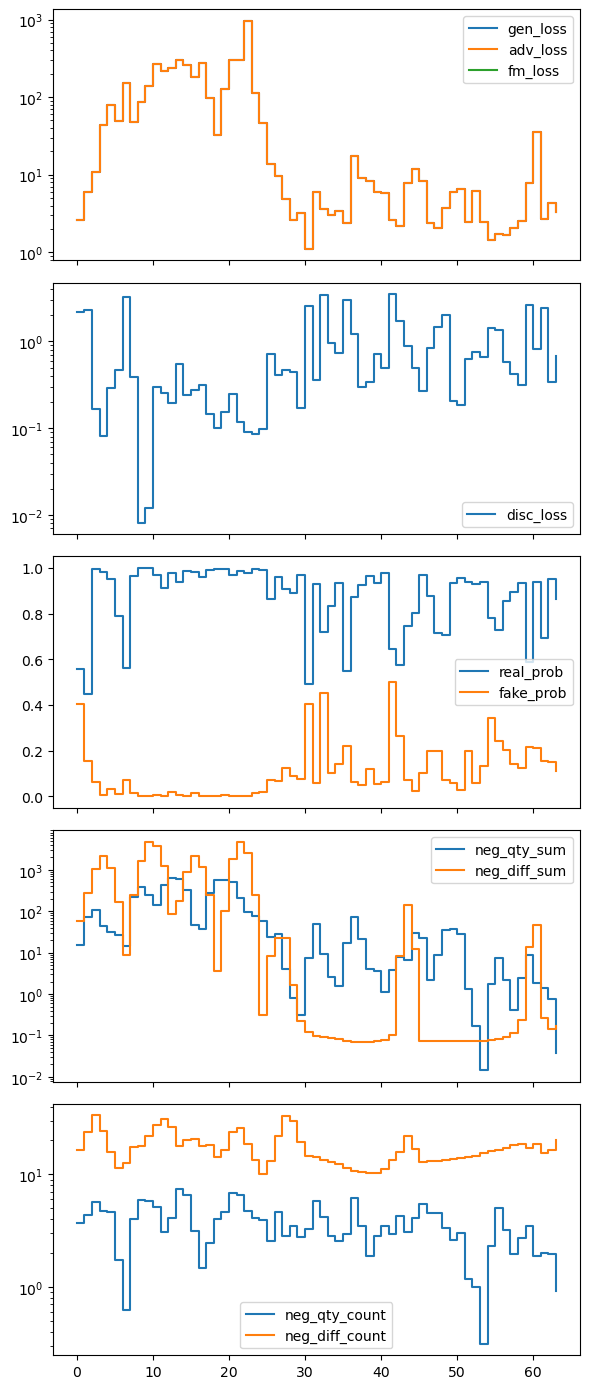

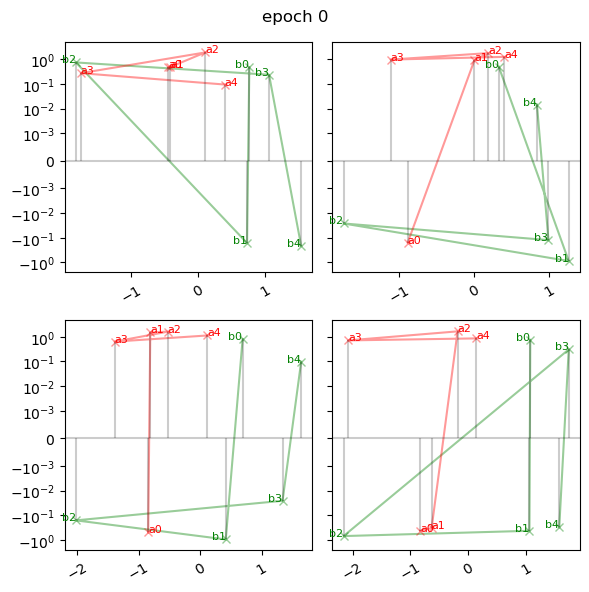

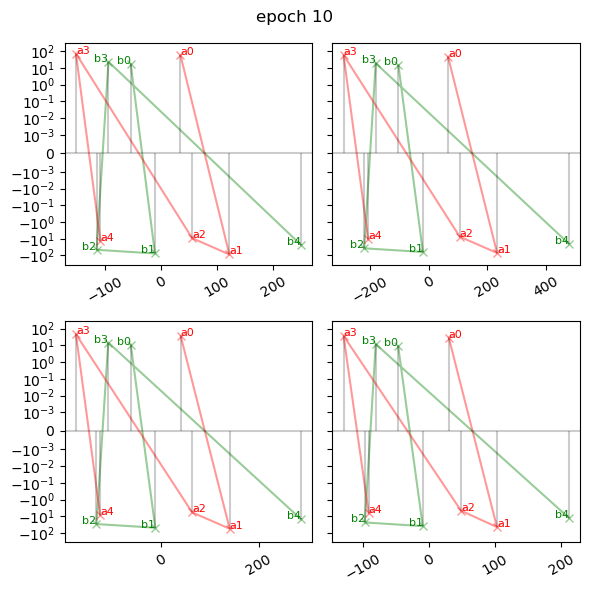

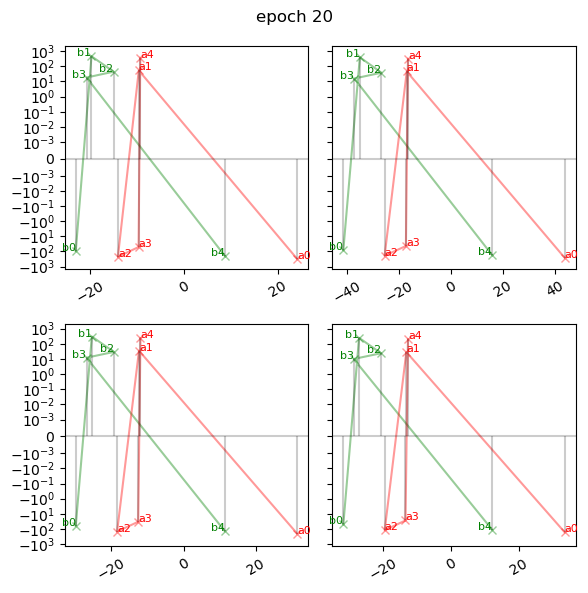

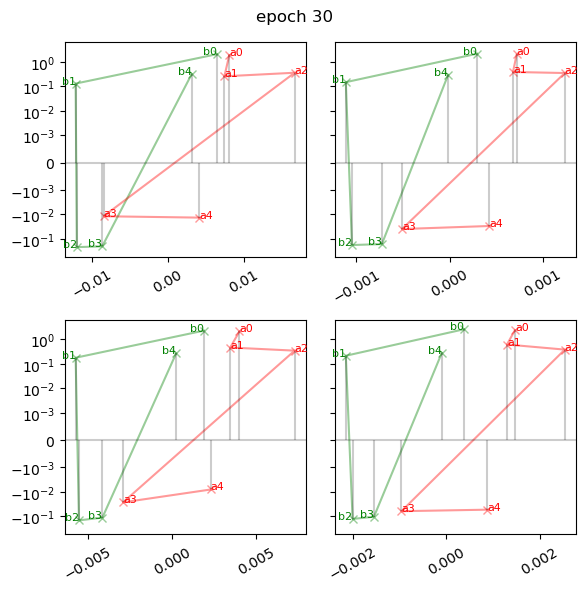

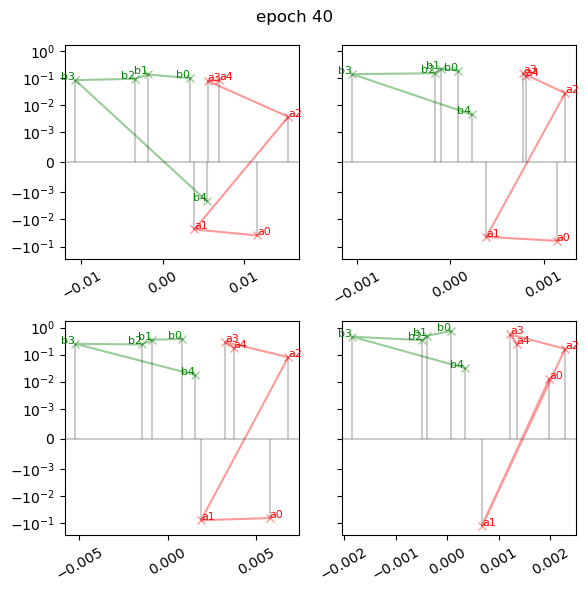

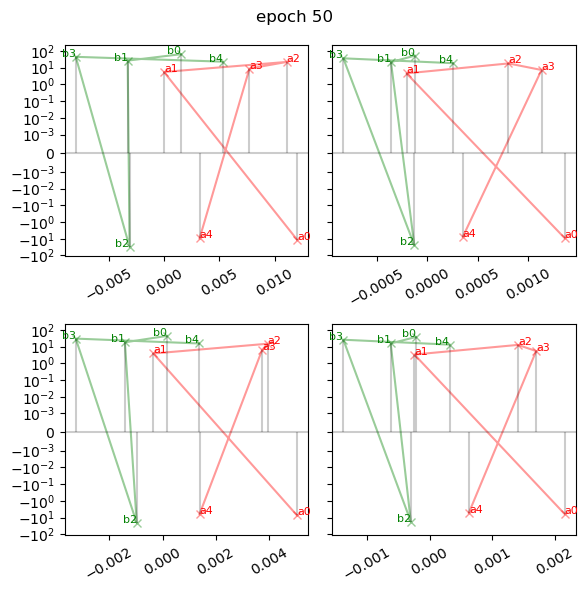

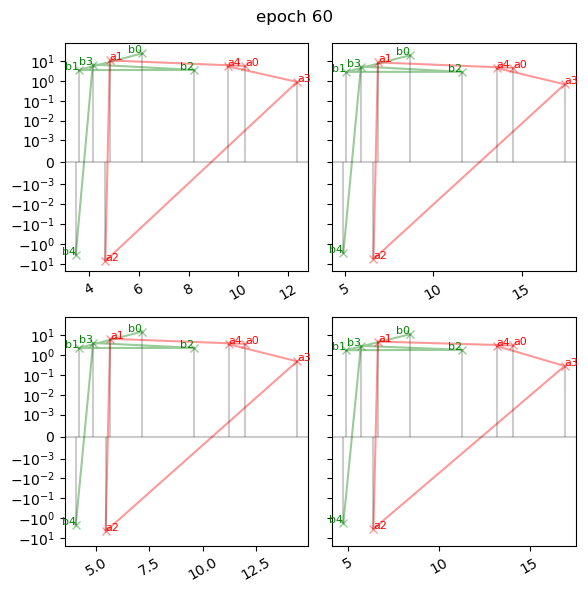

In [7]:
gan = ImprovedGAN(RAW_DATA, Configs(fm_multiplier=0.0))
generated_lobs, metrics = gan.train()
plot_training_history(metrics)
plot_lobs(generated_lobs)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [01:06<00:00,  1.04s/it]

Training completed in 1.11 minutes
plot_training_history


,disc_loss,gen_loss,adv_loss,fm_loss,real_prob,fake_prob,neg_qty_sum,neg_qty_count,neg_diff_sum,neg_diff_count
0,2.351159,1.516429,1.516429,0.000000,0.532848,4.132662e-01,9.422170,3.21310,94.842693,25.899699
1,0.939139,1089.724049,8.620023,1081.104012,0.712138,1.119600e-01,9.389931,1.70410,7.684786,4.748200
2,0.025430,55.044612,24.834921,30.209692,0.990610,3.332951e-10,0.055835,0.10195,0.000522,0.009100
3,0.000100,51.755178,27.871720,23.883458,0.999938,1.671479e-11,0.005109,0.03525,0.005884,0.081100
4,0.000010,38.325677,22.593728,15.731948,0.999990,2.778040e-08,0.000000,0.00000,0.002615,0.054300
...,...,...,...,...,...,...,...,...,...,...
59,0.057364,33.541430,12.637858,20.903572,0.983925,1.676537e-02,0.003296,0.22080,0.000942,2.601650
60,0.119941,33.437263,12.998088,20.439175,0.971743,2.402837e-02,0.002836,0.21395,0.000963,2.797900
61,0.146627,41.455281,19.609060,21.846221,0.978814,2.166733e-02,0.004379,0.26570,0.000976,2.912000
62,0.045278,32.058239,10.740131,21.318109,0.987552,1.431475e-02,0.002255,0.24045,0.001029,3.124800


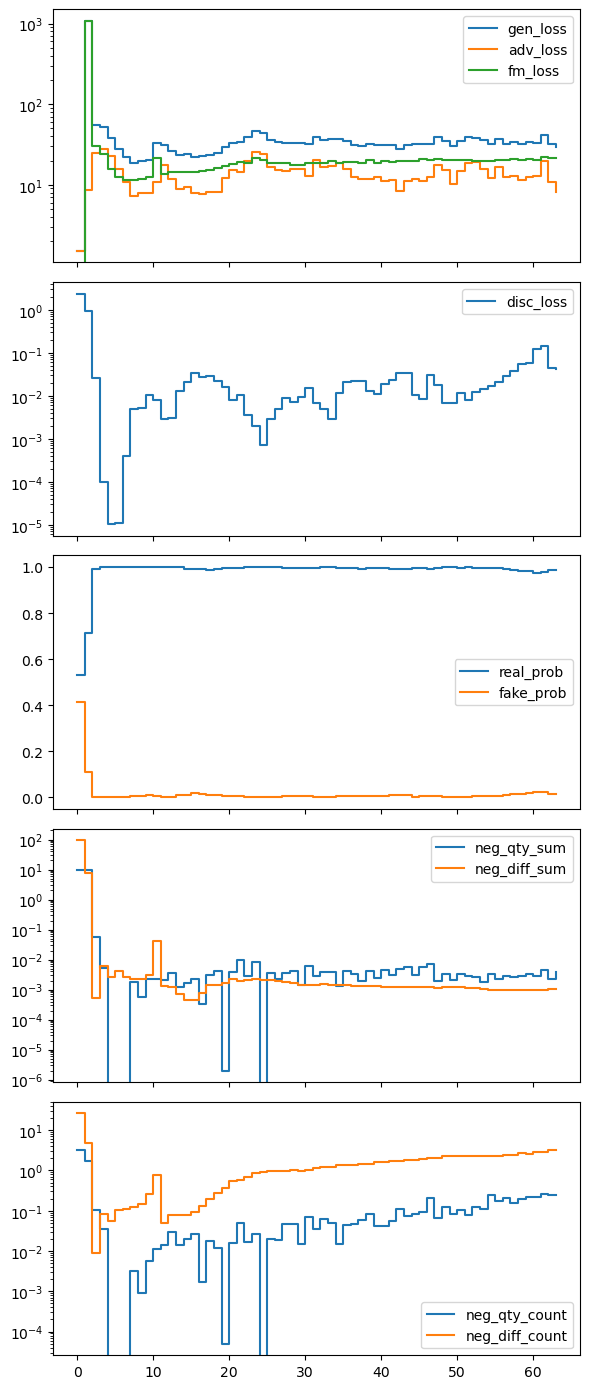

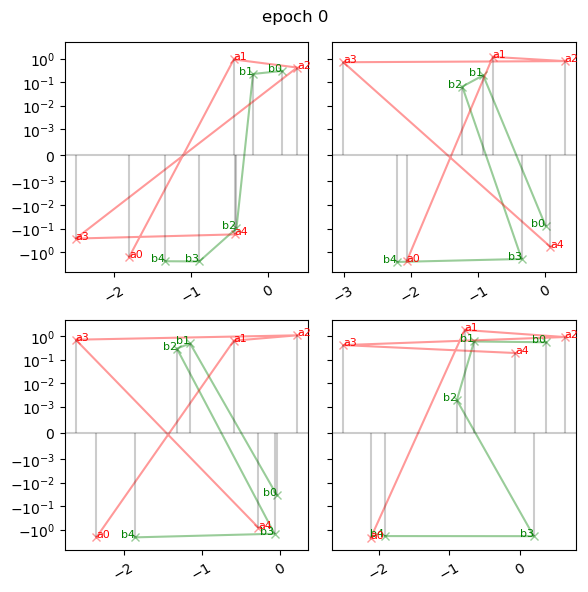

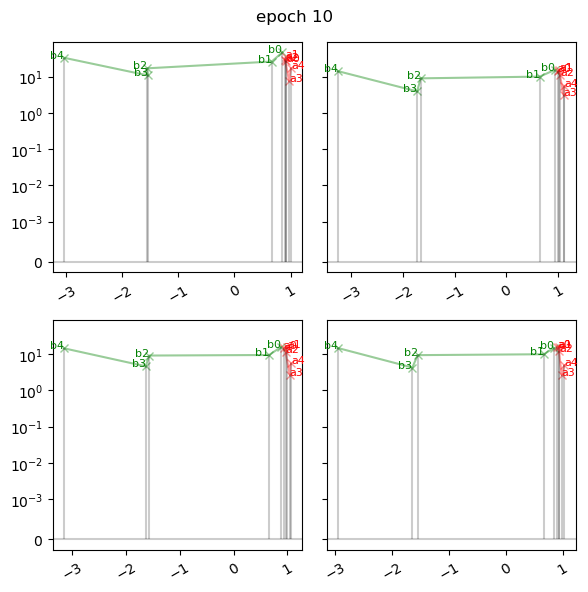

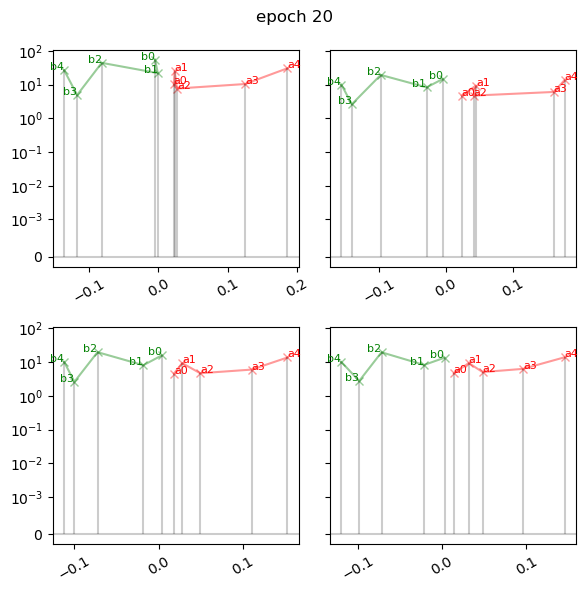

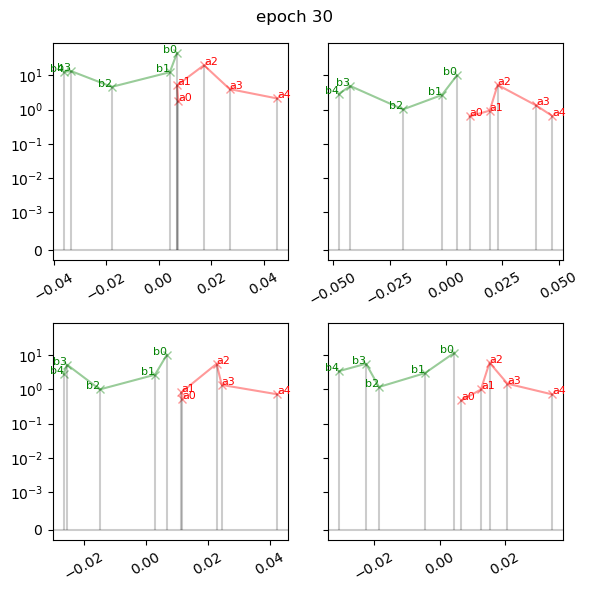

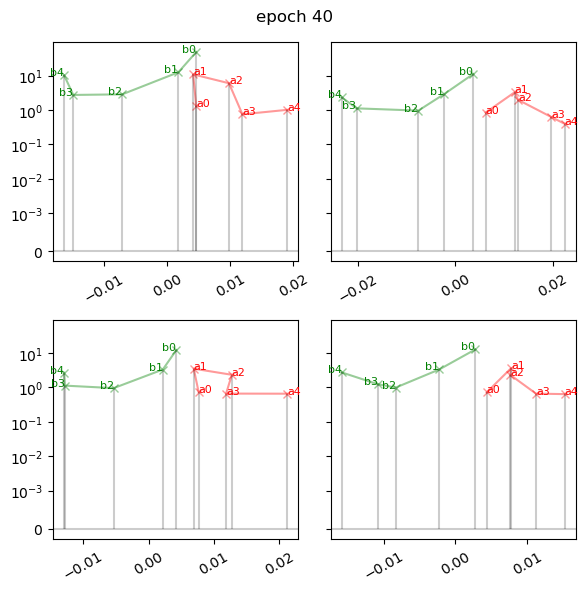

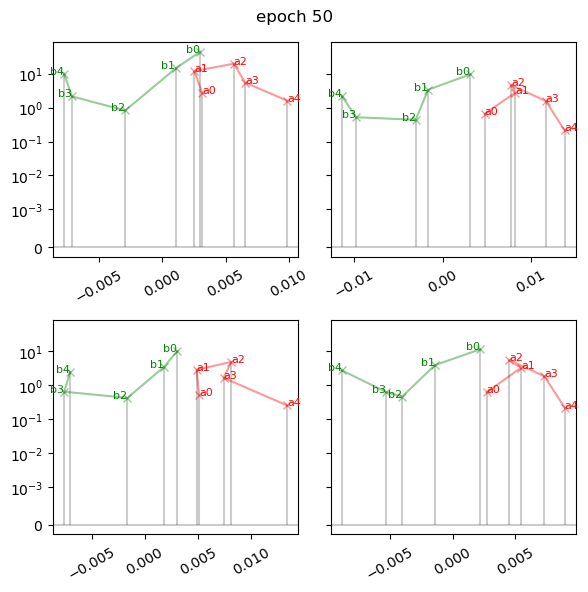

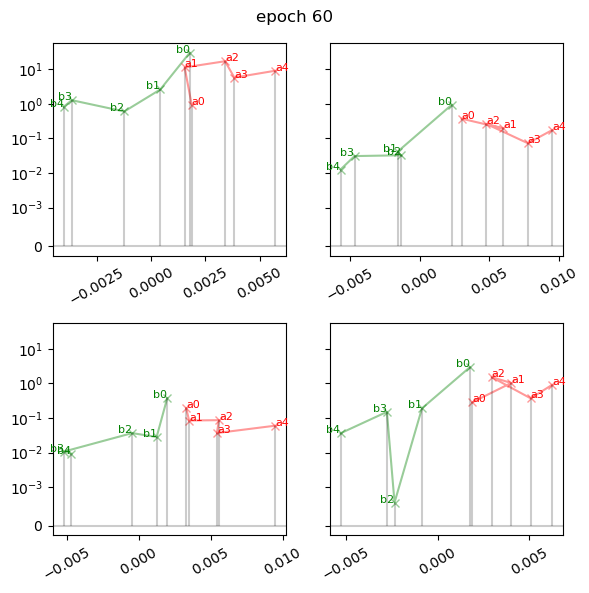

In [8]:
gan = ImprovedGAN(RAW_DATA, Configs(fm_multiplier=0.1))
generated_lobs, metrics = gan.train()
plot_training_history(metrics)
plot_lobs(generated_lobs)